In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 1323
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.vistanet_correct import *
from utils.train import *
from typing import *
from collections import Counter

from utils.load_raw_yelp import *
from utils.dataset import *
from utils.train import *
config

{'task': 'CLS',
 'embedding_dim': 200,
 'embedding': None,
 'freeze_embedding': False,
 'word_hidden_size': 50,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 50,
 'sentence_layers': 1,
 'img_input_size': 4096,
 'visual_attention_size': 100,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0}

In [2]:
config["embedding_dim"] = 100
config["word_hidden_size"] = 100
config["sentence_hidden_size"] = 200
config["freeze_embedding"] = True
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': True,
 'word_hidden_size': 100,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 200,
 'sentence_layers': 1,
 'img_input_size': 4096,
 'visual_attention_size': 100,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0}

In [3]:
batch_size = 64
workers = 4
train_set, valid_set, test_set= load_glove_data(config)
train_loader, valid_loader, test_loader = get_yelp_raw_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
print(get_parameter_number(model))

_interval = 5
lr = 1e-3
epoches = 50
stoping_step = 5
optimizer = get_regal_optimizer(model, optim.AdamW, lr)

viz = get_Visdom()
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)
text_writer = VisdomTextWriter(viz, "Training")

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

res, model = train_visdom_v2(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer, text_writer,
                         _interval=_interval, early_stop=stoping_step)
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.7/lib/python3.8/site-packages/torch/nn/modules/rnn.py:58: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
Setting up a new session...


{'Total': 6824705, 'Trainable': 2606405}


No 1 epoch: 554it [01:29,  6.18it/s]
No 2 epoch: 554it [01:30,  6.15it/s]
No 3 epoch: 554it [01:30,  6.11it/s]
No 4 epoch: 554it [01:30,  6.12it/s]
No 5 epoch: 554it [01:30,  6.15it/s]
No 6 epoch: 554it [01:30,  6.12it/s]
No 7 epoch: 554it [01:30,  6.14it/s]
No 8 epoch: 554it [01:30,  6.15it/s]
No 9 epoch: 554it [01:31,  6.08it/s]
No 10 epoch: 554it [01:30,  6.12it/s]
No 11 epoch: 554it [01:30,  6.13it/s]
No 12 epoch: 554it [01:31,  6.06it/s]
No 13 epoch: 554it [01:32,  6.01it/s]
No 14 epoch: 554it [01:32,  6.00it/s]


ValueError: too many values to unpack (expected 2)

In [4]:
def eval_model_on_raw_yelp(model, loss, test_loaders, use_cuda=True):
    all_true = []
    all_pred = []
    total_loss = 0.
    res = {}
    for key, loader in test_loaders.items():
        y_true, y_pred, _loss= predict(model, loader, loss, use_cuda)
        acc, f1 = evalute(y_true, y_pred)
        res[key] = {"Accuracy" : acc, "F1" : f1, "Loss" : _loss}
        all_true += y_true
        all_pred += y_pred
        total_loss += _loss * len(y_pred)
    
    acc, f1 = evalute(all_true, all_pred)
    total_loss /= len(all_pred)
    res["Total"] = {"Accuracy" : acc, "F1" : f1, "Loss" : total_loss}
    return res

In [6]:
eval_model_on_raw_yelp(model, loss, test_loader)

/home/ly/miniconda3/envs/torch1.7/lib/python3.8/site-packages/torch/nn/modules/rnn.py:742: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/aten/src/ATen/native/cudnn/RNN.cpp:775.)
  result = _VF.gru(input, batch_sizes, hx, self._flat_weights, self.bias,


{'Boston': {'Accuracy': 0.5841269841269842,
  'F1': 0.569626403124968,
  'Loss': 0.910969156689114},
 'Chicago': {'Accuracy': 0.6369230769230769,
  'F1': 0.6278240443971788,
  'Loss': 0.8876715836158166},
 'Los Angeles': {'Accuracy': 0.589544235924933,
  'F1': 0.584862128499984,
  'Loss': 0.9395281629332268},
 'New York': {'Accuracy': 0.5906705539358601,
  'F1': 0.5828530587323066,
  'Loss': 0.9328003084694332},
 'San Francisco': {'Accuracy': 0.5508771929824562,
  'F1': 0.5445296608802402,
  'Loss': 0.9860727046665393},
 'Total': {'Accuracy': 0.588580015026296,
  'F1': 0.5824484465096971,
  'Loss': 0.9378967043513378}}

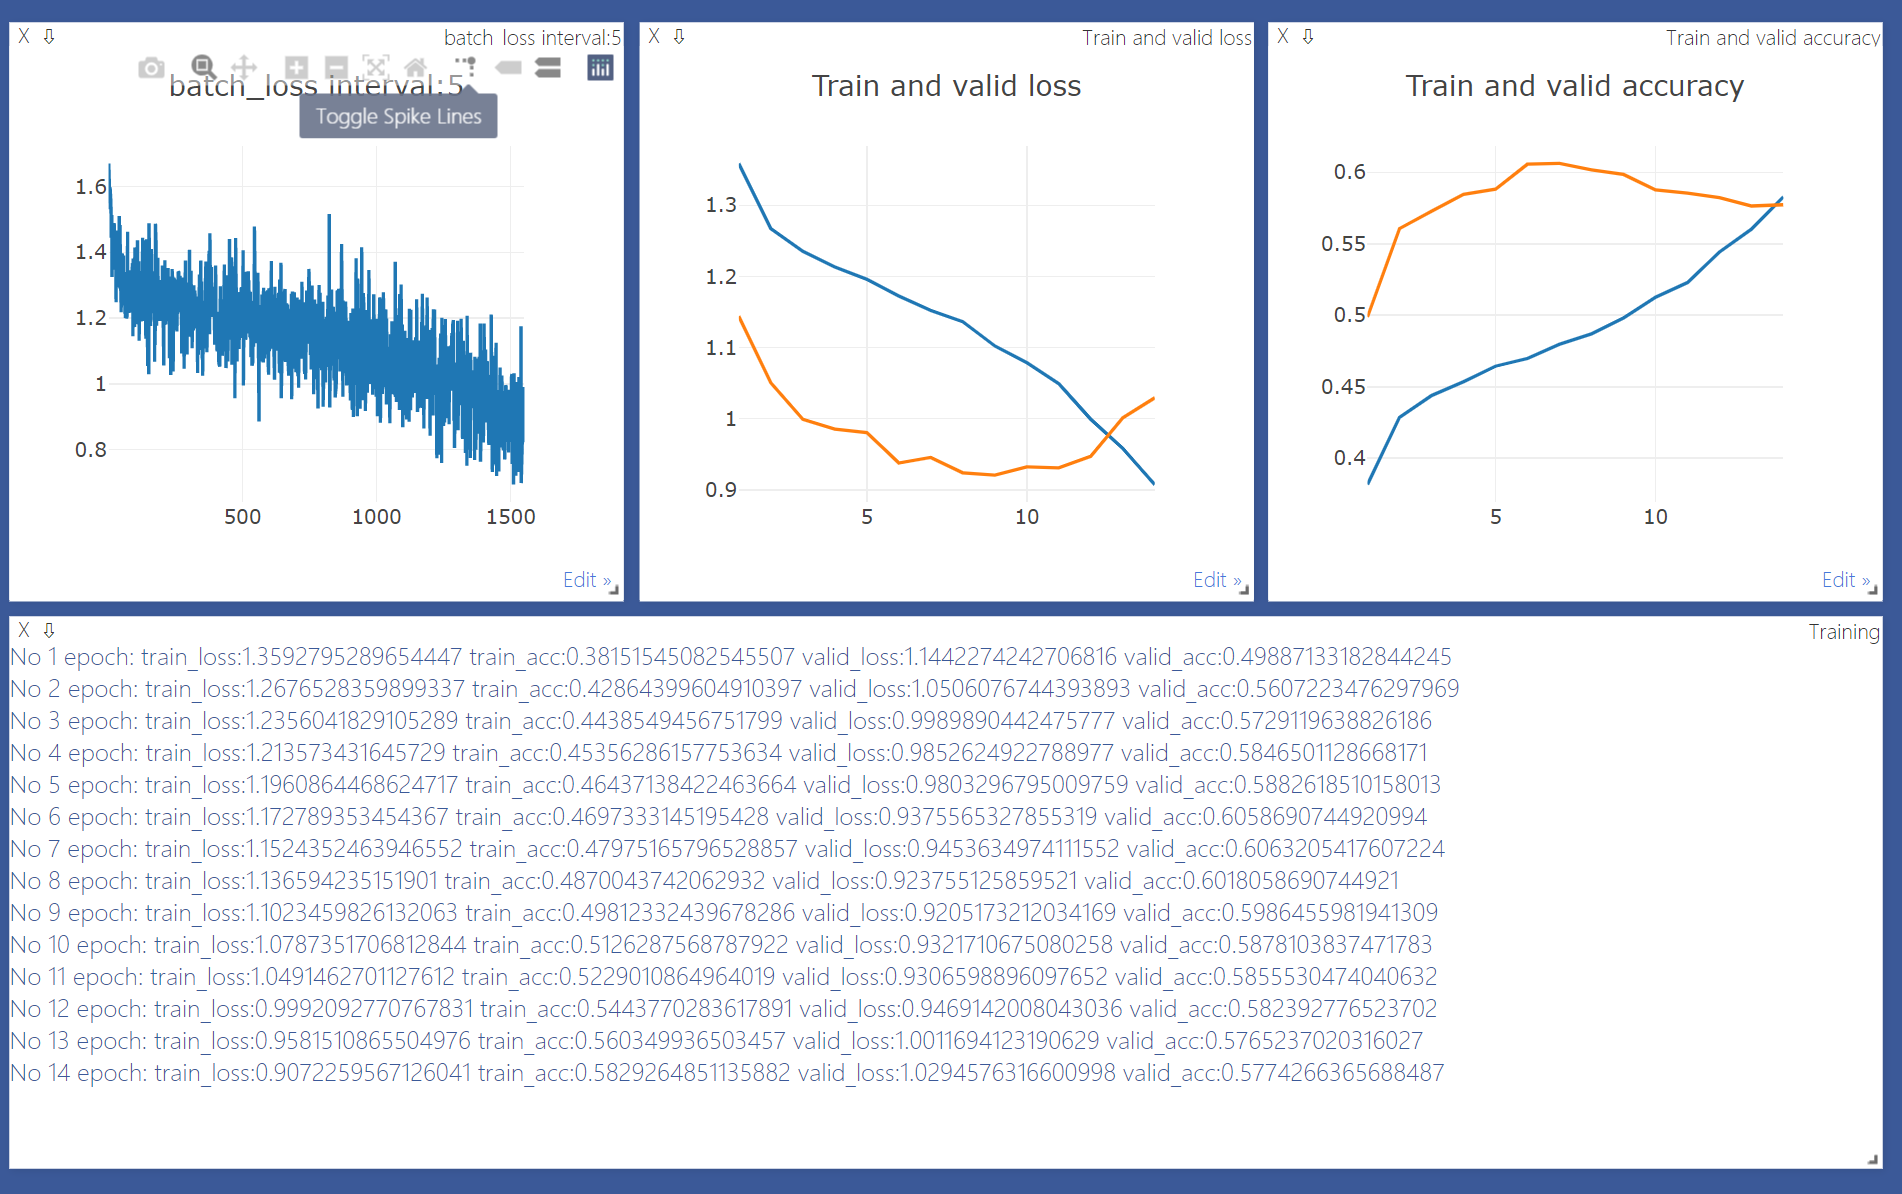